<a href="https://colab.research.google.com/github/Himagination/NLP_Transformers/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets transformers --quiet

     |████████████████████████████████| 311 kB 24.7 MB/s 
     |████████████████████████████████| 3.8 MB 54.7 MB/s 
     |████████████████████████████████| 212 kB 71.6 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.0 MB/s 
     |████████████████████████████████| 134 kB 75.3 MB/s 
     |████████████████████████████████| 6.5 MB 67.3 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 895 kB 66.2 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 70.3 MB/s 
     |████████████████████████████████| 144 kB 74.5 MB/s 


In [2]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 3268 datasets currently available on the Hub
The first 10 are: ['assin', 'ar_res_reviews', 'ambig_qa', 'bianet', 'ag_news', 'ajgt_twitter_ar', 'aeslc', 'bc2gm_corpus', 'air_dialogue', 'acronym_identification']


In [3]:
from datasets import load_dataset
emotions = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
len(train_ds), train_ds[0], train_ds[1]

(16000,
 {'label': 0, 'text': 'i didnt feel humiliated'},
 {'label': 0,
  'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'})

In [6]:
train_ds.column_names

['text', 'label']

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)}


In [8]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [9]:
# From Datasets to DataFrames
# Changing Datasets to DataFrames does not change underlying data format(which is an Arrow table)
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
# Create corresponding label_name for label
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Becoming one with the Data

- Looking at Class Distribution
- How long are our tweets?

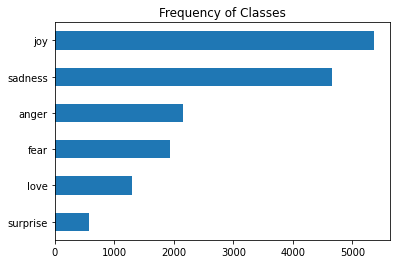

In [11]:
# Looking at class distribution
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


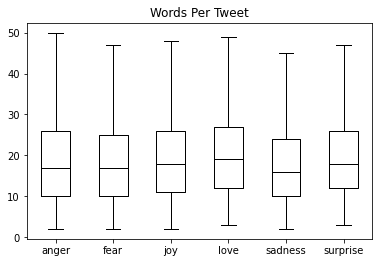

In [12]:
# How long are our tweets?
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [13]:
# Reset the data format as we don't need DataFrame anymore
emotions.reset_format()

In [14]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [15]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [16]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [17]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Transformers as Feature Extraction

In [19]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [25]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [26]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [27]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a Feature Matrix

In [28]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [29]:
# Visualizing the training set
!pip install umap-learn --quiet
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 1.1 MB 47.4 MB/s 


In [32]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.360506,7.363998,0
1,-2.610889,6.328196,0
2,5.512846,3.942826,3
3,-1.905204,4.380431,2
4,-3.086103,4.282516,3


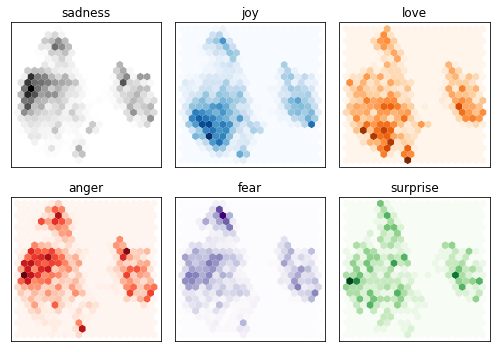

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label=={i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

### Training a Simple Classifier

In [35]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

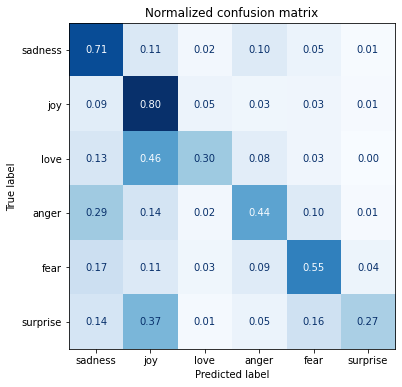

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

In [38]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [39]:
# Defining the performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [44]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=2, 
                                  learning_rate=2e-5, 
                                  per_device_train_batch_size=batch_size, 
                                  per_device_eval_batch_size=batch_size, 
                                  weight_decay=0.01, 
                                  evaluation_strategy="epoch", 
                                  disable_tqdm=False, 
                                  logging_steps=logging_steps, 
                                  push_to_hub=False, 
                                  log_level="error")

In [45]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics, 
                  train_dataset=emotions_encoded["train"], 
                  eval_dataset=emotions_encoded["validation"], 
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.827400,0.321492,0.903500,0.900540
2,0.249800,0.218886,0.924000,0.924198


TrainOutput(global_step=500, training_loss=0.5386261215209961, metrics={'train_runtime': 257.3046, 'train_samples_per_second': 124.366, 'train_steps_per_second': 1.943, 'total_flos': 720342861696000.0, 'train_loss': 0.5386261215209961, 'epoch': 2.0})

In [46]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_accuracy': 0.924,
 'test_f1': 0.9241984049651456,
 'test_loss': 0.2188858985900879,
 'test_runtime': 5.3901,
 'test_samples_per_second': 371.051,
 'test_steps_per_second': 5.937}

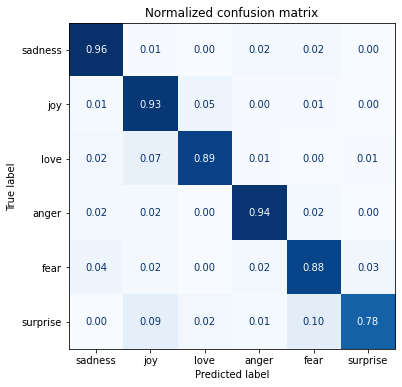

In [47]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

## Error Analysis

In [52]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(), 
          "predicted_label": pred_label.cpu().numpy()}

In [53]:
# Convert dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [54]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [55]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1509,i guess this is a memoir so it feels like that...,joy,fear,5.420448
1963,i called myself pro life and voted for perry w...,joy,sadness,5.347192
882,i feel badly about reneging on my commitment t...,love,sadness,5.268695
1950,i as representative of everything thats wrong ...,surprise,anger,5.151064
1801,i feel that he was being overshadowed by the s...,love,sadness,5.125154
1111,im lazy my characters fall into categories of ...,joy,fear,5.065073
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.934549
1274,i am going to several holiday parties and i ca...,joy,sadness,4.915857
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.815516
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.802295
